In [71]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import seaborn as sns

from sklearn.metrics import mean_squared_error as mse_score

import mxnet as mx
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

from model import LSTMExogModel
import utils
import train
import data
from models.tcn import TCN, TCN2

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generate data from a SARIMA process.

In [41]:
# (p, 0, 0) x (1, 0, 0)_T
p = 10
T = 50
ar_coefs = np.random.random(p) / p
seasonal_coef = 0.5
n_train = 10000

train_seq = seq = data._gen_stationary(n_train, ar_coefs, T, seasonal_coef)
valid_seq = seq = data._gen_stationary(n_train // 2, ar_coefs, T, seasonal_coef)

Timeseries plot shows that we have autocorrelation at lags 1 - 10, and at lag 50 (seasonal correlation)

<IPython.core.display.Javascript object>


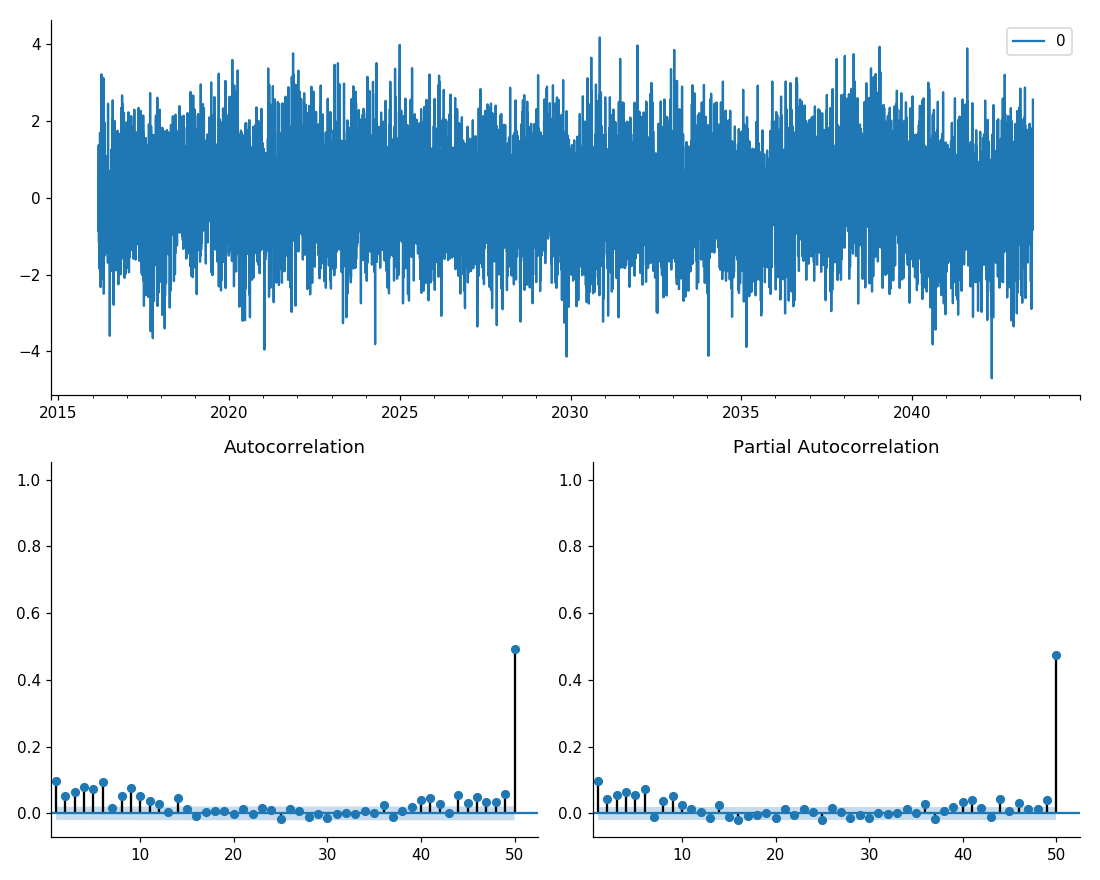

In [61]:
utils.tsplot(data.make_index(train_seq.asnumpy()), lags=50);

Since we know the generation process, we can specify it correctly using a SARIMA model and that will give us the best possible error. The leftover error is due to noise.

In [62]:
arima = smt.SARIMAX(data.make_index(train_seq.asnumpy()), order=(10, 0, 0), seasonal_order=(1, 0, 0, 50))
res = arima.fit()

In [63]:
print("Error = %0.3f" % (0.5 * np.mean((train_seq.asnumpy() - res.predict())**2)))

Error = 0.482


In [76]:
batch_size = 64
input_seq_len = 100  # experiment with this number!!
ar_coefs = np.random.random(10) / 10
output_seq_len = 1
num_layers = 1
feature_dim = 1
learning_rate = 0.001
kernel_size = 3
channel_list = [5, 5, 5, 5, 5]

model = TCN(channel_list, feature_dim, input_seq_len, output_seq_len, kernel_size=kernel_size)
print('model aperture: %d' % model.tcn.aperture)
model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': learning_rate})

datasets = {'train': data.TSArrayDataset(train_seq, input_seq_len),
            'valid': data.TSArrayDataset(valid_seq, input_seq_len)}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

model aperture: 62


In [77]:
train.train_epochs_tcn(model, loaders, loss, trainer, num_epochs=40, log_interval=5, ctx=[mx.cpu()])

[Epoch 5] train loss = 0.999
[Epoch 10] train loss = 0.644
[Epoch 15] train loss = 0.596
[Epoch 20] train loss = 0.553
[Epoch 25] train loss = 0.521
[Epoch 30] train loss = 0.502
[Epoch 35] train loss = 0.489
[Epoch 40] train loss = 0.481


How do we do if we don't include 50 lags, but add it as an exogenous variable?

In [80]:
batch_size = 64
input_seq_len = 100
ar_coefs = np.random.random(10) / 10
output_seq_len = 1
num_layers = 1
feature_dim = 1
learning_rate = 0.001
kernel_size = 3
channel_list = [5, 5, 5]

model = TCN(channel_list, feature_dim, input_seq_len, output_seq_len, kernel_size=kernel_size)
print('model aperture: %d' % model.tcn.aperture)
model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': learning_rate})

datasets = {'train': data.TSArrayDataset(train_seq, input_seq_len, exog_lags=[40]),
            'valid': data.TSArrayDataset(valid_seq, input_seq_len, exog_lags=[40])}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

model aperture: 14


In [81]:
train.train_epochs_tcn(model, loaders, loss, trainer, num_epochs=30, log_interval=5, ctx=[mx.cpu()])

[Epoch 5] train loss = 0.702
[Epoch 10] train loss = 0.644
[Epoch 15] train loss = 0.635
[Epoch 20] train loss = 0.629
[Epoch 25] train loss = 0.626
[Epoch 30] train loss = 0.623


In [49]:
pred_steps = 100
pred_ds = data.TSArrayDataset(valid_seq, input_seq_len, out_seq_len=pred_steps, exog_lags=[50])
loader = gluon.data.DataLoader(pred_ds, batch_size=batch_size, last_batch='discard')
(predict_input, exog), predict_target = next(iter(loader))
pred_outputs = model.predict_dynamic((predict_input, exog), pred_steps)

<IPython.core.display.Javascript object>


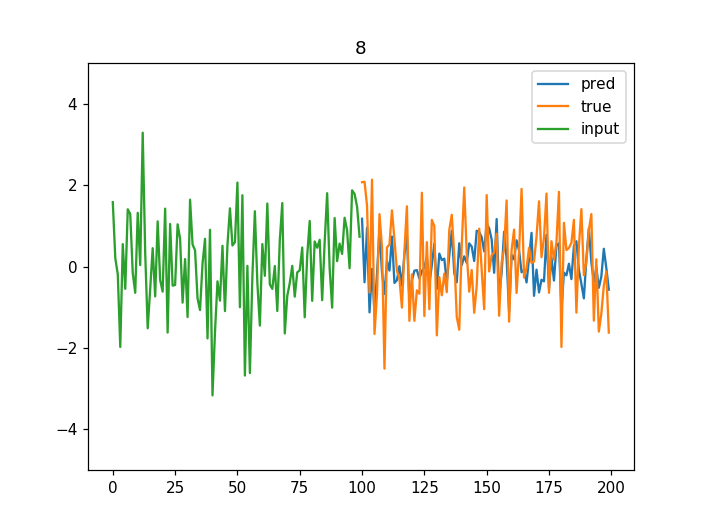

In [52]:
idx = np.random.randint(batch_size)
# idx = 26
fig, ax = plt.subplots()
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), pred_outputs[idx].asnumpy().ravel(), label='pred')
# ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), t_outputs[idx].asnumpy().ravel(), label='pred_tcn')
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), predict_target[idx].asnumpy().ravel(), label='true')
ax.plot(np.arange(input_seq_len), predict_input[idx].asnumpy().ravel(), label='input')
# ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), exog_input[idx].asnumpy().ravel())
ax.set_title(idx)
ax.set_ylim(-5, 5)
ax.legend();